# Run the pipeline classification by file OR with cells below

## By file

In [ ]:

import sys
sys.path.insert(1, 'C:\\Users\\jamilah\\Documents\\Sourceforge_analysis_PROJECTS\\Motor_classification\\')

from e_classification.main_script import *

# ------------------------------
# Run all classification combinations by a single file
# ------------------------------
main_script()

## By cells (for troubleshooting and it runs 4 to 6 times faster than the textfile with interpretor)

In [1]:
import pickle
import numpy as np
import pandas as pd
import time

from scipy import signal
from collections import Counter

from sklearn.model_selection import train_test_split

import sys
sys.path.insert(1, 'C:\\Users\\jamilah\\Documents\\Github_analysis_PROJECTS\\Motor_classification')
from c_calculate_metrics.put_timeseries_trialdata_into_pandas import *

# Personal python functions
from subfunctions.make_a_properlist import *
from subfunctions.numderiv import *
from subfunctions.freqresp_functions import get_freqresp_mag_phase, select_fc, select_filter
from subfunctions.freq_from_sig_timecounting import *
from subfunctions.freq_from_sig_freqresp import *
from subfunctions.my_dropna_python import *
from subfunctions.scale_feature_data import *
from subfunctions.normal_distribution_feature_data import *
from subfunctions.findall import *
from subfunctions.explode_without_colnames1 import *
from subfunctions.scikit_functions_binaryclass import * 

df_timeseries_exp = put_timeseries_trialdata_into_pandas()

In [ ]:
print('shape of df_timeseries_exp[rot] : ', df_timeseries_exp['rot'].shape)
df_timeseries_exp['rot'].tail()

In [ ]:
print('shape of df_timeseries_exp[trans] : ', df_timeseries_exp['trans'].shape)
df_timeseries_exp['trans'].tail()

In [ ]:
def get_df(ax_val, ss_val):
    
    if ax_val == 'all' and ss_val == 'all':
        # All the data
        df_timeseries_exp[exp].head()
        df = df_timeseries_exp[exp]
    elif ax_val != 'all' and ss_val == 'all':
        # Prediction for each axis
        if ax_val == 'ax0':
            ax_val_n = 0
        elif ax_val == 'ax1':
            ax_val_n = 1
        elif ax_val == 'ax2':
            ax_val_n = 2
        df = df_timeseries_exp[exp][(df_timeseries_exp[exp].ax == ax_val_n)]
    elif ax_val == 'all' and ss_val != 'all':
        # Prediction per sup/sub
        if ss_val == 'sup':  # sup
            df = df_timeseries_exp[exp][(df_timeseries_exp[exp].ss > 0)]
        elif ss_val == 'sub':  # sub
            df = df_timeseries_exp[exp][(df_timeseries_exp[exp].ss < 0)]
    elif ax_val != 'all' and ss_val != 'all':
        # Prediction per axis and sup/sub
        if ax_val == 'ax0':
            ax_val_n = 0
        elif ax_val == 'ax1':
            ax_val_n = 1
        elif ax_val == 'ax2':
            ax_val_n = 2
        
        if ss_val == 'sup':  # sup
            df = df_timeseries_exp[exp][(df_timeseries_exp[exp].ss > 0) & (df_timeseries_exp[exp].ax == ax_val_n)]
        elif ss_val == 'sub':  # sub
            df = df_timeseries_exp[exp][(df_timeseries_exp[exp].ss < 0) & (df_timeseries_exp[exp].ax == ax_val_n)]

    print('Confirmation : exp=', exp, ', ax_val=', ax_val, ', ss_val=', ss_val)
    
    # Reset the index
    df.reset_index(drop=True, inplace=True)
    
    return df

In [ ]:
# Get the joystick stimulus axis data and put it in a pandas column
def indexit(row):
    joy_mat = [row.JOY_ax0, row.JOY_ax1, row.JOY_ax2]
    return joy_mat[int(row.ax)]

In [ ]:
def create_labels_and_initial_feature(df):
    # IC = 1
    # EC = 2, 4, 5
    # NC = 3, 6, 7
    # NR = 9
    # (IC) - sham (do not use) = 8
    # (NC) - sham (do not use) = 10

    # Just to confirm, what are the unique values of res_type
    df.res_type.value_counts(ascending=True)

    # Construction of SD_label : How do we define disorientation?

    # Way 0 : lenient
    # 0 = If participates got the result CORRECT for the trial, they were NOT disoriented. (IC, EC)
    # 1 = If participates got the result WRONG or did not respond, they were disoriented. (NC, NR)

    idx_NDS = df.index[(df.res_type == 1) | (df.res_type == 2) | (df.res_type == 4) | (df.res_type == 5)].to_list()
    idx_DS = df.index[(df.res_type == 3) | (df.res_type == 6) | (df.res_type == 7) | (df.res_type == 9)].to_list()
    df.lenient = ''  # define a new column , rows 8 and 10 will be NaN, need to do dropna for rows
    df.loc[idx_NDS, 'lenient'] = 0
    df.loc[idx_DS, 'lenient'] = 1

    # -------------------------------------

    # Way 1 : strict simple
    # 0 = If participants got the result initially CORRECT, they were NOT disoriented. (IC)
    # 1 = If participants were WRONG at any point, they were disoriented. (EC, NC, NR)

    idx_NDS = df.index[(df.res_type == 1)].to_list()
    idx_DS = df.index[(df.res_type == 2) | (df.res_type == 4) | (df.res_type == 5) | (df.res_type == 3) | (df.res_type == 6) | (df.res_type == 7) | (df.res_type == 9)].to_list()
    df.strict = ''  # define a new column
    df.loc[idx_NDS, 'strict'] = 0
    df.loc[idx_DS, 'strict'] = 1

    # Way 2 : st_complex
    # 0 = If participants got the result initially CORRECT, they were NOT disoriented. (IC)
    # 1 = If participants got the result eventually CORRECT, they were MILDLY disoriented. (EC)
    # 2 = If participants were WRONG for the trial, they were disoriented. (NC, NR)

    idx_NDS = df.index[(df.res_type == 1)].to_list()
    idx_MDS = df.index[(df.res_type == 2) | (df.res_type == 4) | (df.res_type == 5)].to_list()
    idx_DS = df.index[(df.res_type == 3) | (df.res_type == 6) | (df.res_type == 7) | (df.res_type == 9)].to_list()
    df.st_complex = ''  # define a new column
    df.loc[idx_NDS, 'st_complex'] = 0
    df.loc[idx_MDS, 'st_complex'] = 1
    df.loc[idx_DS, 'st_complex'] = 2

    # -------------------------------------

    # Create features :  (1) position
    df['joy_stim'] = df.apply(indexit, axis='columns')  # fill in joy_stim

    # -------------------------------------

    # Make DataFrame for trial start-stop index
    # Cut the data up per trial across subjects
    tr_vec = df.tr.to_numpy()

    st = [0]
    ender = []
    for i in range(len(tr_vec)-1):
        if tr_vec[i] != tr_vec[i+1]:
            st = st + [i+1]
            ender = ender + [i]
    ender = ender + [len(tr_vec)-1]

    # See start-stop index clearly
    e0 = np.reshape(st, (len(st),1))
    e1 = np.reshape(ender, (len(st),1))
    data = np.ravel(e0), np.ravel(e1)
    data = np.transpose(data)
    columns = ['stind', 'endind']
    temp = pd.DataFrame(data=data, columns=columns)

    # -------------------------------------

    # Find the longest trial signal in df_rot['joy_stim']
    temp['diff'] = temp.endind - temp.stind
    temp['timediff'] = [df.time.iloc[temp.endind[i]] - df.time.iloc[temp.stind[i]] for i in range(len(temp.endind))]
    outmin = temp['diff'].min()
    outmax = temp['diff'].max()

    tomin = temp['timediff'][(temp['diff'] == outmin)]
    tomax = temp['timediff'][(temp['diff'] == outmax)]
    # print('outmin : ', outmin, 't :', tomin)
    # print('outmax : ', outmax, 't :', tomax)

    # -------------------------------------

    # Interpolate : make each trial the same number of data points
    from scipy.interpolate import interp1d
    feat0 = []
    t_feat0 = []
    y1_feat0 = []
    y2_feat0 = []
    y3_feat0 = []
    for i in range(len(temp.stind)):
        
        # X
        sSIG = df['joy_stim'][temp.stind.iloc[i]:temp.endind.iloc[i]].to_numpy()
        t_sSIG = df['time'][temp.stind.iloc[i]:temp.endind.iloc[i]].to_numpy()

        # labels
        y1 = df['lenient'][temp.stind.iloc[i]:temp.endind.iloc[i]].to_numpy()
        y2 = df['strict'][temp.stind.iloc[i]:temp.endind.iloc[i]].to_numpy()
        y3 = df['st_complex'][temp.stind.iloc[i]:temp.endind.iloc[i]].to_numpy()
        
        # Check if trial data is less than the maximum length
        if len(df['joy_stim'][temp.stind.iloc[i]:temp.endind.iloc[i]]) < outmax:
            
            # The trial length is different so interpolate the time-series to make them the same length signal 
            x = np.linspace(sSIG[0], len(sSIG), num=len(sSIG), endpoint=True)
            xnew = np.linspace(sSIG[0], len(sSIG), num=outmax, endpoint=True)

            # joystick on stim
            f = interp1d(x, sSIG)
            sSIGl = f(xnew)

            # time
            f = interp1d(x, t_sSIG)
            t_sSIGl = f(xnew)

            # y1
            f = interp1d(x, y1)
            y1_sSIGl = f(xnew)

            # y2
            f = interp1d(x, y2)
            y2_sSIGl = f(xnew)

            # y3
            f = interp1d(x, y3)
            y3_sSIGl = f(xnew)

            # python : you can not create a matrix in real-time in pandas
            # you only assign the full matrix at the end
            # (0) position
            feat0 = feat0 + [sSIGl]
            t_feat0 = t_feat0 + [t_sSIGl]
            y1_feat0 = y1_feat0 + [np.ravel(y1_sSIGl)]
            y2_feat0 = y2_feat0 + [np.ravel(y2_sSIGl)]
            y3_feat0 = y3_feat0 + [np.ravel(y3_sSIGl)]
            
            del x, f, sSIGl, t_sSIGl, y1_sSIGl, y2_sSIGl, y3_sSIGl
        else:
            feat0 = feat0 + [sSIG]
            t_feat0 = t_feat0 + [t_sSIG]
            y1_feat0 = y1_feat0 + [np.ravel(y1)]
            y2_feat0 = y2_feat0 + [np.ravel(y2)]
            y3_feat0 = y3_feat0 + [np.ravel(y3)]

    # Clean up
    del df
    # -------------------------------------
    
    return feat0, t_feat0, y1_feat0, y2_feat0, y3_feat0

In [ ]:
def feature_creation_preprocessing(feat0, t_feat0):

    start = time.time()
    
    # ----------------
    # Make your features
    # ----------------
    norm_feat0 = []
    norm_feat1 = []
    norm_feat2 = []
    norm_feat3 = []
    feat4 = []
    feat4_1 = []
    
    n = 4   # filter order
    fs = 250 # data sampling frequency (Hz)
    fcc = 10  # Cut-off frequency of the filter
    w = fcc / (fs / 2) # Normalize the frequency
    b, a = signal.butter(n, w, 'low')  # 3rd order

    # Need to find when one trial starts and end - take derivative from start-stop periods
    for i in range(len(feat0)):

        if i == 0:
            plotORnot = 0 # 1
        else:
            plotORnot = 0

        # (0) position
        scaled_data0 = scale_feature_data(feat0[i], plotORnot)
        # print('shape of scaled_data0 : ', np.array(scaled_data0).shape)
        # temp0 = normal_distribution_feature_data(scaled_data0, plotORnot)
        norm_feat0 = norm_feat0 + [scaled_data0]

        # (1) velocity
        vel = numderiv(feat0[i], t_feat0[i])
        scaled_data1 = scale_feature_data(vel, plotORnot)
        # temp1 = normal_distribution_feature_data(scaled_data1, plotORnot)
        norm_feat1 = norm_feat1 + [scaled_data1]

        # (2) acceleration
        # the signal is noisy, there is a numerical defect : 1) tried changing the time to see if it would smooth out (does not work), 2) filter

        # shift time to the right by one
        # t_shift = []
        # for b in range(len(t_feat0[i])-1):
            # t_shift.append(t_feat0[i][b+1])
        # t_shift.append(t_feat0[i][-1])
        # acc = numderiv(vel, t_shift)
        acc = numderiv(vel, t_feat0[i])
        filtacc = signal.filtfilt(b, a, acc)

        scaled_data2 = scale_feature_data(filtacc, plotORnot)
        # temp2 = normal_distribution_feature_data(scaled_data2, plotORnot)
        norm_feat2 = norm_feat2 + [scaled_data2]

        # (3) frequency response of joystick via FFT
        Xn_mag_in, Xn_phase_in, omeg_in, Xn_mag_half_db_in, Xn_phase_half_in, omg_half_in = get_freqresp_mag_phase(feat0[i], t_feat0[i], 0.1)
        scaled_data3 = scale_feature_data(Xn_mag_in, plotORnot)
        # temp3 = normal_distribution_feature_data(scaled_data3, plotORnot)
        norm_feat3 = norm_feat3 + [scaled_data3]

        # (4) frequency of joystick : frequency response db cutoff
        dp_jump = 0.5  # this is half the height of the scaled signal scaled_data0
        fc = freq_from_sig_timecounting(scaled_data0, t_feat0[i], 0.1, dp_jump)
        fc1 = freq_from_sig_freqresp(feat0[i], t_feat0[i], ts=0.1, plotORnot=0)
        temp4 = fc*np.ones((len(feat0[i])))
        feat4 = feat4 + [temp4]

        temp4_1 = fc1*np.ones((len(feat0[i])))
        feat4_1 = feat4_1 + [temp4_1]

        # print('fc = ', fc, ', fc1 = ', fc1)

        # (5) integral error with respect to theoretical stimuli (this is really part of the control response)
        # diff = feat0[i] - theoretical_stim[i]
        # feat5 = feat5 + [diff]

    # Clean up
    del n, fs, fcc, w, b, a, plotORnot
    del feat0, t_feat0, scaled_data0, vel, scaled_data1, scaled_data2, filtacc
    del Xn_mag_in, Xn_phase_in, omeg_in, Xn_mag_half_db_in, Xn_phase_half_in, omg_half_in, scaled_data3
    del fc, fc1
    # ----------------

    end = time.time()
    print('Elasped time for feature processing : ', end - start)

    return norm_feat0, norm_feat1, norm_feat2, norm_feat3, feat4, feat4_1

In [ ]:
def get_feature_samples_per_label(norm_feat0, norm_feat1, norm_feat2, norm_feat3, feat4, feat4_1, y_label):
    
    # This gets X samples of each feature for a unique label value
    
    # Find the unique label values of y_feat0
    # So we have feature samples that correspond to each label value
    y_vals = np.unique(y_label)
    # print('y_vals : ', y_vals)
    y_vals2 = [y_vals[b] for b in range(len(y_vals)) if np.isnan(y_vals[b]) == False]
    # print('y_vals2 : ', y_vals2)
    
    v = 0
    
    # Max number of randomly sampled time-series over trials to keep 
    max2keep = len(y_vals2)*2   # Keep 2 feature samples per unique label 
    # print('max2keep : ', max2keep)
    
    tot_samps = 0
    samp_f0 = {}
    samp_f1 = {}
    samp_f2 = {}
    samp_f3 = {}
    samp_f4 = {}
    samp_f4_1 = {}
    
    y_check = []
    
    for i in range(len(norm_feat0)):
        # Keep some dummy trial time-series for padding to make classes have the same 
        # number of data points/samples
        if np.isclose(np.random.permutation(len(norm_feat0))[0], i, atol=10) and tot_samps < max2keep and np.isnan(norm_feat0[i]).any() == False:
            
            # Check what the label is for this trial
            # print('y_vals2[v] : ', y_vals2[v])
            # print('y_label[i][0] : ', y_label[i][0])
            if y_vals2[v] == y_label[i][0]:
                samp_f0[tot_samps] = norm_feat0[i]
                samp_f1[tot_samps] = norm_feat1[i]
                samp_f2[tot_samps] = norm_feat2[i]
                samp_f3[tot_samps] = norm_feat3[i]
                samp_f4[tot_samps] = feat4[i]
                samp_f4_1[tot_samps] = feat4_1[i]
                
                y_check.append(y_vals2[v])  # This lets us map the sample to the class
                
                tot_samps = tot_samps + 1
                # print('v : ', v)
                if v < len(y_vals2)-1:
                    v = v + 1
                else:
                    # Reset counter for indexing across unique labels
                    v = 0
    
    return samp_f0, samp_f1, samp_f2, samp_f3, samp_f4, samp_f4_1, y_check

In [ ]:
def pad_data_2makeclasses_equivalent(norm_feat0, norm_feat1, norm_feat2, norm_feat3, feat4, feat4_1, y_label, samp_f0, samp_f1, samp_f2, samp_f3, samp_f4, samp_f4_1, y_check):
    
    # Keep the original index of each class

    # Reassign for the unique classes
    y_check = np.unique(y_check_org)
    print('y_check : ', y_check)

    # ----------------

    print('length of y_label : ', len(y_label))

    first_val = []
    for g in range(len(y_label)):
        first_val.append(y_label[g][0])
    print('length of first_val : ', len(first_val))
    #print('first_val : ', first_val)

    c = Counter(first_val)
    print('c : ', c)
    yval_counts = [c[y_check[i]] for i in range(len(y_check))]
    print('yval_counts : ', yval_counts)

    # Get the number of samples that each class needs to equal to the class with the max values
    needed_samps_class = np.max(yval_counts) - yval_counts
    print('needed_samps_class : ', needed_samps_class)

    # ----------------

    n_classes = len(yval_counts)

    for i in range(n_classes):
        print('i : ', i)
        # Pad short length classes
        for j in range(needed_samps_class[i]):

            # Want to select different collected samples of the same class
            # Get all the values from y_check_org that equal y_check[i]
            newvec, ind_newvec = findall(y_check_org, '==', y_check[i])

            # Randomly select one of the samples for the class
            ri = np.random.permutation(len(ind_newvec))[0]
            print('ri : ', ri)
            rand_index = ind_newvec[ri]
            print('rand_index : ', rand_index)

            norm_feat0.append(samp_f0[rand_index])
            norm_feat1.append(samp_f1[rand_index])
            norm_feat2.append(samp_f2[rand_index])
            norm_feat3.append(samp_f3[rand_index])
            feat4.append(samp_f4[rand_index])
            feat4_1.append(samp_f4_1[rand_index])

            q = len(samp_f4_1[rand_index])
            y_label.append(y_check[i]*np.ones((1,q)))
    
    return norm_feat0, norm_feat1, norm_feat2, norm_feat3, feat4, feat4_1, y_label

In [ ]:
# Plotting columns from featlab: pandas
plotORnot = 0
if plotORnot == 1:
    # Plot all the data (data is too large : can not do it)
    pd.options.plotting.backend = "plotly"
    fig = featlab.loc[:,8].plot()
    fig.show()

In [5]:
def preprocess_df_2_XYtraintest(featlab_new, fea, ynum):
    # ----------------
    # Check to see if each y label has a balanced number of class samples
    # ----------------
    num_of_feat = 6
    test_size = 0.25 # default

    # ----------------
    # Order of which features to use in a model : 1) All features, 
    # 2) first 3 from permutation_importance, 
    # 3) first 2 from permutation_importance, 
    # 4) first feature from permutation_importance
    if fea == 0:
        # 1) All features
        X_part = list(range(num_of_feat))
        y_part = num_of_feat+ynum
        desired_col = make_a_properlist([X_part, y_part])
    elif fea == 1:
        # 2) first 3 from permutation_importance
        desired_col = []
        # Add features for X
        for oo in range(3): 
            if ovtot[oo][0] == 'joy':
                desired_col.append(0)
            elif ovtot[oo][0] == 'joy1derv':
                desired_col.append(1)
            elif ovtot[oo][0] == 'joy2derv':
                desired_col.append(2)
            elif ovtot[oo][0] == 'fres':
                desired_col.append(3)
            elif ovtot[oo][0] == 'freq_t':
                desired_col.append(4)
            elif ovtot[oo][0] == 'freq_fres':
                desired_col.append(5)
        # Add label y
        desired_col.append(num_of_feat+ynum)
        desired_col = np.ravel(desired_col)
    elif fea == 2:
        # 3) first 2 from permutation_importance
        desired_col = []
        for oo in range(2): 
            if ovtot[oo][0] == 'joy':
                desired_col.append(0)
            elif ovtot[oo][0] == 'joy1derv':
                desired_col.append(1)
            elif ovtot[oo][0] == 'joy2derv':
                desired_col.append(2)
            elif ovtot[oo][0] == 'fres':
                desired_col.append(3)
            elif ovtot[oo][0] == 'freq_t':
                desired_col.append(4)
            elif ovtot[oo][0] == 'freq_fres':
                desired_col.append(5)
        # Add label y
        desired_col.append(num_of_feat+ynum)
        desired_col = np.ravel(desired_col)
    elif fea == 3:
        # 4) first feature from permutation_importance
        if ovtot[0][0] == 'joy':
            vvv = 0
        elif ovtot[0][0] == 'joy1derv':
            vvv = 1
        elif ovtot[0][0] == 'joy2derv':
            vvv = 2
        elif ovtot[0][0] == 'fres':
            vvv = 3
        elif ovtot[0][0] == 'freq_t':
            vvv = 4
        elif ovtot[0][0] == 'freq_fres':
            vvv = 5
        y_part = num_of_feat+ynum
        desired_col = [vvv, y_part]

    print('desired_col : ', desired_col)  # where first columns are X, and last column is y
    df_y = featlab_new.iloc[:, desired_col]

    # ----------------
    
    print('shape of df_y : ', df_y.shape)
    df_y.head()
    
    # ----------------
    
    # Explode the vectors
    print('Explode the vectors')
    df_y1 = explode_without_colnames1(df_y)
    
    # ----------------
    
    # Remove nan value per row
    print('dropna')
    # df_y1.dropna(axis=0)
    # OR
    df_y2 = my_dropna_python(df_y1)

    # ----------------

    out = np.isnan(df_y2).any()
    print('are there nan valeus in the data : ', out)

    # ----------------

    # Divide DataFrame into X and y
    a = df_y2.shape[1]
    print('a : ', a)

    X = df_y2.iloc[:,0:a-1]
    X = X.to_numpy()
    print('shape of X : ', X.shape)

    y = df_y2.iloc[:,a-1:a].to_numpy()
    y = np.reshape(y, (len(y), 1))
    print('length of y : ', len(y))

    # Check if the y label is correct (only 0's and 1's)
    print('y :', y)

    # ----------------

    # Split the X an y data into test and train
    seed = 0
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state = seed, test_size = test_size)
    print('X_train : ', len(X_train))

    X_train = np.array(X_train)
    print('shape of X_train : ', X_train.shape)
    Y_train = np.array(Y_train)
    print('shape of Y_train : ', Y_train.shape)
    X_test = np.array(X_test)
    print('shape of X_test : ', X_test.shape)
    Y_test = np.array(Y_test)
    print('shape of Y_test : ', Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test, desired_col

fea :  0
desired_col :  [0, 1, 2, 3, 4, 5, 6]
shape of df_y :  (636, 7)
Explode the vectors
shape of df :  (299556, 7)
dropna
are there nan valeus in the data :  0    False
1    False
2    False
3    False
4    False
5    False
6    False
dtype: bool
a :  7
shape of X :  (272709, 6)
length of y :  272709
y : [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
X_train :  204531
shape of X_train :  (204531, 6)
shape of Y_train :  (204531, 1)
shape of X_test :  (68178, 6)
shape of Y_test :  (68178, 1)


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


shape of Y_train_bin_pp :  (204531, 2)
shape of Y_test_bin_pp :  (68178, 2)
shape of Y_train_1D_score :  (204531,)
shape of Y_test_1D_score :  (68178,)


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

acc_crossval :  [0.65915369 0.66139442 0.66234782 0.66014766 0.66332567]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

prec_crossval :  [0.64542961 0.64902317 0.6470562  0.64708275 0.64990067]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

recall_crossval :  [0.70326279 0.69986772 0.71128313 0.70148449 0.70517343]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

rocauc_crossval :  [0.71560925 0.71657401 0.71959995 0.71558998 0.7173274 ]
matrix_of_counts :  [[63368 39106]
 [30259 71798]]
matrix_normalized :  [[0.30982101 0.1911984 ]
 [0.14794334 0.35103725]]
acc_dircalc :  0.6608582562056607
prec_dircalc :  0.6608582562056607
recall_dircalc :  0.6608582562056607
f1_dircalc :  0.6608582562056607
fbeta_dircalc0_5 :  0.6608582562056607
fbeta_dircalc1 :  0.6608582562056607
fbeta_dircalc2 :  0.6608582562056607
prec_recall_f_dircalc :  (0.6608582562056607, 0.6608582562056607, 0.6608582562056607, None)
shape of Y_1D :  (204531, 1)
shape of Y_1D_pp :  (204531,)
rocauc_pp_dircalc :  0.5221851079188442
rocauc_df_dircalc :  0.7169753684977814
shape of Y_bin :  (204531, 2)
roc_auc1 :  [0.7169753684977813, 0.7169753684977814]


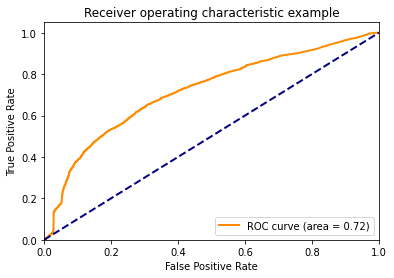

value_pack_train :  [array([0.65915369, 0.66139442, 0.66234782, 0.66014766, 0.66332567]), array([0.64542961, 0.64902317, 0.6470562 , 0.64708275, 0.64990067]), array([0.70326279, 0.69986772, 0.71128313, 0.70148449, 0.70517343]), array([0.71560925, 0.71657401, 0.71959995, 0.71558998, 0.7173274 ]), 0.3098210051288069, 0.19119840024250603, 0.14794334355183322, 0.35103725107685385, 0.6608582562056607, 0.6608582562056607, 0.6608582562056607, 0.6608582562056607, 0.6608582562056607, 0.6608582562056607, 0.6608582562056607, (0.6608582562056607, 0.6608582562056607, 0.6608582562056607, None), 0.5221851079188442, 0.7169753684977814, 0.7169753684977814]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

acc_crossval :  [0.66317102 0.66529774 0.66273101 0.6620462  0.66534653]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


prec_crossval :  [0.65209047 0.65313904 0.64883033 0.64803869 0.65144781]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

recall_crossval :  [0.69832648 0.70394833 0.70835168 0.70816207 0.71007046]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

rocauc_crossval :  [0.72002335 0.72086922 0.72033524 0.71788358 0.72199375]
matrix_of_counts :  [[21235 12881]
 [ 9953 24109]]
matrix_normalized :  [[0.31146411 0.18893191]
 [0.14598551 0.35361847]]
acc_dircalc :  0.665082577957699
prec_dircalc :  0.665082577957699
recall_dircalc :  0.665082577957699
f1_dircalc :  0.665082577957699
fbeta_dircalc0_5 :  0.665082577957699
fbeta_dircalc1 :  0.665082577957699
fbeta_dircalc2 :  0.665082577957699
prec_recall_f_dircalc :  (0.665082577957699, 0.665082577957699, 0.665082577957699, None)
shape of Y_1D :  (68178, 1)
shape of Y_1D_pp :  (68178,)
rocauc_pp_dircalc :  0.5238973644296082
rocauc_df_dircalc :  0.7201850290944559
shape of Y_bin :  (68178, 2)
roc_auc1 :  [0.720185029094456, 0.7201850290944559]


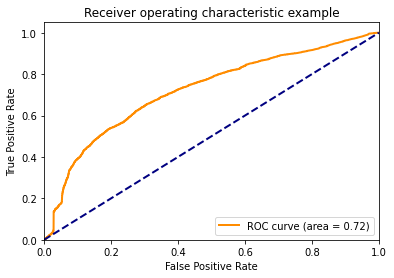

value_pack_test :  [array([0.66317102, 0.66529774, 0.66273101, 0.6620462 , 0.66534653]), array([0.65209047, 0.65313904, 0.64883033, 0.64803869, 0.65144781]), array([0.69832648, 0.70394833, 0.70835168, 0.70816207, 0.71007046]), array([0.72002335, 0.72086922, 0.72033524, 0.71788358, 0.72199375]), 0.31146410865675145, 0.1889319135204905, 0.14598550852181055, 0.35361846930094754, 0.665082577957699, 0.665082577957699, 0.665082577957699, 0.665082577957699, 0.665082577957699, 0.665082577957699, 0.665082577957699, (0.665082577957699, 0.665082577957699, 0.665082577957699, None), 0.5238973644296082, 0.7201850290944559, 0.7201850290944559]
ovtot :  [('joy2derv', 0.143851389011118, 0.0017480821539078613), ('freq_fres', 0.04093695913637833, 0.0009560907323612815), ('joy', 0.040571738684032986, 0.001736266956395639), ('freq_t', 0.001013523423978424, 0.000382281563507941)]
fea :  1
desired_col :  [2 5 0 6]
shape of df_y :  (636, 4)
Explode the vectors
shape of df :  (299556, 4)
dropna
are there nan v

C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


shape of Y_train_bin_pp :  (204531, 2)
shape of Y_test_bin_pp :  (68178, 2)
shape of Y_train_1D_score :  (204531,)
shape of Y_test_1D_score :  (68178,)


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

acc_crossval :  [0.66829638 0.66889943 0.66850829 0.66870386 0.67156407]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

prec_crossval :  [0.64957377 0.65104923 0.64876015 0.6503705  0.65272974]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

recall_crossval :  [0.72795414 0.72505022 0.73190926 0.72671599 0.73040368]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

rocauc_crossval :  [0.71433559 0.71488672 0.71684718 0.71441768 0.71553975]
matrix_of_counts :  [[62554 39920]
 [27714 74343]]
matrix_normalized :  [[0.30584117 0.19517824]
 [0.13550024 0.36348035]]
acc_dircalc :  0.6693215209430355
prec_dircalc :  0.6693215209430355
recall_dircalc :  0.6693215209430355
f1_dircalc :  0.6693215209430355
fbeta_dircalc0_5 :  0.6693215209430355
fbeta_dircalc1 :  0.6693215209430355
fbeta_dircalc2 :  0.6693215209430355
prec_recall_f_dircalc :  (0.6693215209430355, 0.6693215209430355, 0.6693215209430355, None)
shape of Y_1D :  (204531, 1)
shape of Y_1D_pp :  (204531,)
rocauc_pp_dircalc :  0.5231263769074861
rocauc_df_dircalc :  0.7152154742686445
shape of Y_bin :  (204531, 2)
roc_auc1 :  [0.7152154742686445, 0.7152154742686445]


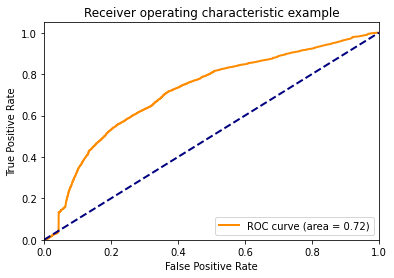

value_pack_train :  [array([0.66829638, 0.66889943, 0.66850829, 0.66870386, 0.67156407]), array([0.64957377, 0.65104923, 0.64876015, 0.6503705 , 0.65272974]), array([0.72795414, 0.72505022, 0.73190926, 0.72671599, 0.73040368]), array([0.71433559, 0.71488672, 0.71684718, 0.71441768, 0.71553975]), 0.305841168331451, 0.19517823703986192, 0.13550024201710253, 0.36348035261158457, 0.6693215209430355, 0.6693215209430355, 0.6693215209430355, 0.6693215209430355, 0.6693215209430355, 0.6693215209430355, 0.6693215209430355, (0.6693215209430355, 0.6693215209430355, 0.6693215209430355, None), 0.5231263769074861, 0.7152154742686445, 0.7152154742686445]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

acc_crossval :  [0.67395131 0.67343796 0.66977119 0.6683535  0.67260726]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

prec_crossval :  [0.65652289 0.65591966 0.65039062 0.64928292 0.65310381]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

recall_crossval :  [0.72842043 0.72860707 0.7331572  0.73106283 0.73517322]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


rocauc_crossval :  [0.71920766 0.7190941  0.71889332 0.71477273 0.71978061]
matrix_of_counts :  [[20904 13212]
 [ 9158 24904]]
matrix_normalized :  [[0.30660917 0.19378685]
 [0.13432486 0.36527912]]
acc_dircalc :  0.6718882924110416
prec_dircalc :  0.6718882924110416
recall_dircalc :  0.6718882924110416
f1_dircalc :  0.6718882924110416
fbeta_dircalc0_5 :  0.6718882924110416
fbeta_dircalc1 :  0.6718882924110416
fbeta_dircalc2 :  0.6718882924110416
prec_recall_f_dircalc :  (0.6718882924110416, 0.6718882924110416, 0.6718882924110416, None)
shape of Y_1D :  (68178, 1)
shape of Y_1D_pp :  (68178,)
rocauc_pp_dircalc :  0.5247047871551107
rocauc_df_dircalc :  0.7179452580759759
shape of Y_bin :  (68178, 2)
roc_auc1 :  [0.7179452580759759, 0.7179452580759759]


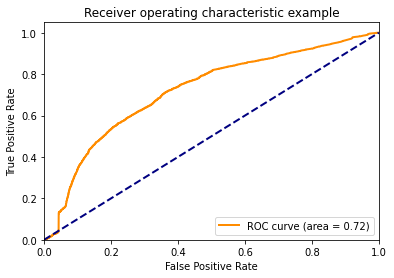

value_pack_test :  [array([0.67395131, 0.67343796, 0.66977119, 0.6683535 , 0.67260726]), array([0.65652289, 0.65591966, 0.65039062, 0.64928292, 0.65310381]), array([0.72842043, 0.72860707, 0.7331572 , 0.73106283, 0.73517322]), array([0.71920766, 0.7190941 , 0.71889332, 0.71477273, 0.71978061]), 0.30660917011352634, 0.19378685206371557, 0.13432485552524276, 0.3652791222975153, 0.6718882924110416, 0.6718882924110416, 0.6718882924110416, 0.6718882924110416, 0.6718882924110416, 0.6718882924110416, 0.6718882924110416, (0.6718882924110416, 0.6718882924110416, 0.6718882924110416, None), 0.5247047871551107, 0.7179452580759759, 0.7179452580759759]
fea :  2
desired_col :  [2 5 6]
shape of df_y :  (636, 3)
Explode the vectors
shape of df :  (299556, 3)
dropna
are there nan valeus in the data :  0    False
1    False
2    False
dtype: bool
a :  3
shape of X :  (272709, 2)
length of y :  272709
y : [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
X_train :  204531
shape of X_train :  (204531, 2)
shape of 

C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


shape of Y_test_bin_pp :  (68178, 2)
shape of Y_train_1D_score :  (204531,)
shape of Y_test_1D_score :  (68178,)


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

acc_crossval :  [0.66069377 0.66004987 0.66325233 0.66066103 0.66051435]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

prec_crossval :  [0.63834293 0.63890668 0.64102346 0.63925616 0.63917922]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

recall_crossval :  [0.7382912  0.73293812 0.73891529 0.73430993 0.734029  ]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

rocauc_crossval :  [0.69702031 0.6968759  0.69951941 0.69504935 0.69620985]
matrix_of_counts :  [[60117 42357]
 [26951 75106]]
matrix_normalized :  [[0.2939261  0.2070933 ]
 [0.13176976 0.36721084]]
acc_dircalc :  0.6611369425661635
prec_dircalc :  0.6611369425661635
recall_dircalc :  0.6611369425661635
f1_dircalc :  0.6611369425661635
fbeta_dircalc0_5 :  0.6611369425661634
fbeta_dircalc1 :  0.6611369425661635
fbeta_dircalc2 :  0.6611369425661634
prec_recall_f_dircalc :  (0.6611369425661635, 0.6611369425661635, 0.6611369425661634, None)
shape of Y_1D :  (204531, 1)
shape of Y_1D_pp :  (204531,)
rocauc_pp_dircalc :  0.535471885654534
rocauc_df_dircalc :  0.6969665133183769
shape of Y_bin :  (204531, 2)
roc_auc1 :  [0.6969665133183769, 0.6969665133183769]


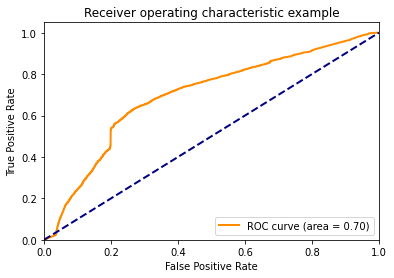

value_pack_train :  [array([0.66069377, 0.66004987, 0.66325233, 0.66066103, 0.66051435]), array([0.63834293, 0.63890668, 0.64102346, 0.63925616, 0.63917922]), array([0.7382912 , 0.73293812, 0.73891529, 0.73430993, 0.734029  ]), array([0.69702031, 0.6968759 , 0.69951941, 0.69504935, 0.69620985]), 0.2939261041113572, 0.2070933012599557, 0.13176975617388073, 0.36721083845480634, 0.6611369425661635, 0.6611369425661635, 0.6611369425661635, 0.6611369425661635, 0.6611369425661634, 0.6611369425661635, 0.6611369425661634, (0.6611369425661635, 0.6611369425661635, 0.6611369425661634, None), 0.535471885654534, 0.6969665133183769, 0.6969665133183769]
acc_crossval :  [0.66793781 0.6637577  0.66478439 0.66255959 0.66028603]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

prec_crossval :  [0.6465982  0.64212809 0.64089995 0.63960096 0.63843028]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

recall_crossval :  [0.73943042 0.73873477 0.74842213 0.74354081 0.73796242]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

rocauc_crossval :  [0.70119233 0.70202595 0.701928   0.70117263 0.70205412]
matrix_of_counts :  [[20019 14097]
 [ 8823 25239]]
matrix_normalized :  [[0.29362844 0.20676758]
 [0.12941125 0.37019273]]
acc_dircalc :  0.6638211739857433
prec_dircalc :  0.6638211739857433
recall_dircalc :  0.6638211739857433
f1_dircalc :  0.6638211739857433
fbeta_dircalc0_5 :  0.6638211739857433
fbeta_dircalc1 :  0.6638211739857433
fbeta_dircalc2 :  0.6638211739857433
prec_recall_f_dircalc :  (0.6638211739857433, 0.6638211739857433, 0.6638211739857433, None)
shape of Y_1D :  (68178, 1)
shape of Y_1D_pp :  (68178,)
rocauc_pp_dircalc :  0.5371476343865967
rocauc_df_dircalc :  0.7016786783439514
shape of Y_bin :  (68178, 2)
roc_auc1 :  [0.7016786783439514, 0.7016786783439514]


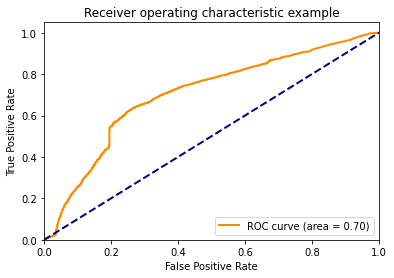

value_pack_test :  [array([0.66793781, 0.6637577 , 0.66478439, 0.66255959, 0.66028603]), array([0.6465982 , 0.64212809, 0.64089995, 0.63960096, 0.63843028]), array([0.73943042, 0.73873477, 0.74842213, 0.74354081, 0.73796242]), array([0.70119233, 0.70202595, 0.701928  , 0.70117263, 0.70205412]), 0.2936284431928188, 0.20676757898442313, 0.12941124702983367, 0.3701927307929244, 0.6638211739857433, 0.6638211739857433, 0.6638211739857433, 0.6638211739857433, 0.6638211739857433, 0.6638211739857433, 0.6638211739857433, (0.6638211739857433, 0.6638211739857433, 0.6638211739857433, None), 0.5371476343865967, 0.7016786783439514, 0.7016786783439514]
fea :  3
desired_col :  [2, 6]
shape of df_y :  (636, 2)
Explode the vectors
shape of df :  (299556, 2)
dropna
are there nan valeus in the data :  0    False
1    False
dtype: bool
a :  2
shape of X :  (275064, 1)
length of y :  275064
y : [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
X_train :  206298
shape of X_train :  (206298, 1)
shape of Y_train :  (2

C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


shape of Y_train_bin_pp :  (206298, 2)
shape of Y_test_bin_pp :  (68766, 2)
shape of Y_train_1D_score :  (206298,)
shape of Y_test_1D_score :  (68766,)


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-p

acc_crossval :  [0.4618032  0.43327678 0.47237033 0.59439153 0.41884195]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-p

prec_crossval :  [0.45914617 0.43976502 0.44466218 0.6408111  0.3582343 ]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-p

recall_crossval :  [0.47596717 0.51927116 0.25494602 0.41527038 0.21645254]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-p

rocauc_crossval :  [0.48056397 0.4351715  0.45118529 0.59034732 0.46037451]
matrix_of_counts :  [[43958 59984]
 [56260 46096]]
matrix_normalized :  [[0.21308011 0.29076385]
 [0.27271229 0.22344376]]
acc_dircalc :  0.4365238635372132
prec_dircalc :  0.4365238635372132
recall_dircalc :  0.4365238635372132
f1_dircalc :  0.4365238635372132
fbeta_dircalc0_5 :  0.4365238635372132
fbeta_dircalc1 :  0.4365238635372132
fbeta_dircalc2 :  0.4365238635372132
prec_recall_f_dircalc :  (0.4365238635372132, 0.4365238635372132, 0.4365238635372132, None)
shape of Y_1D :  (206298, 1)
shape of Y_1D_pp :  (206298,)
rocauc_pp_dircalc :  0.3494143645978404
rocauc_df_dircalc :  0.4295803468650757
shape of Y_bin :  (206298, 2)
roc_auc1 :  [0.5658126117244799, 0.5658126117244799]


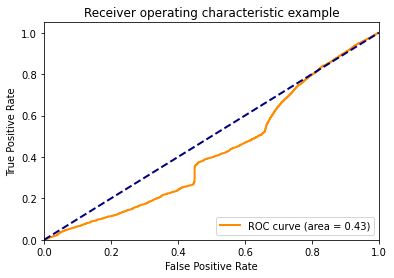

value_pack_train :  [array([0.4618032 , 0.43327678, 0.47237033, 0.59439153, 0.41884195]), array([0.45914617, 0.43976502, 0.44466218, 0.6408111 , 0.3582343 ]), array([0.47596717, 0.51927116, 0.25494602, 0.41527038, 0.21645254]), array([0.48056397, 0.4351715 , 0.45118529, 0.59034732, 0.46037451]), 0.21308010741742528, 0.2907638464745175, 0.2727122899882694, 0.22344375611978787, 0.4365238635372132, 0.4365238635372132, 0.4365238635372132, 0.4365238635372132, 0.4365238635372132, 0.4365238635372132, 0.4365238635372132, (0.4365238635372132, 0.4365238635372132, 0.4365238635372132, None), 0.3494143645978404, 0.4295803468650757, 0.4295803468650757]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-p

acc_crossval :  [0.45143231 0.44622991 0.47960445 0.42805206 0.59710609]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-p

prec_crossval :  [0.35995185 0.44955451 0.38113497 0.38257663 0.73354793]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-p

recall_crossval :  [0.13100628 0.50116857 0.07258653 0.24244195 0.29954725]


C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\jamilah\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-p

rocauc_crossval :  [0.50390117 0.47742092 0.56816865 0.46487251 0.58219409]
matrix_of_counts :  [[14679 19853]
 [18719 15515]]
matrix_normalized :  [[0.21346305 0.28870372]
 [0.27221301 0.22562022]]
acc_dircalc :  0.4390832678940174
prec_dircalc :  0.4390832678940174
recall_dircalc :  0.4390832678940174
f1_dircalc :  0.4390832678940174
fbeta_dircalc0_5 :  0.4390832678940174
fbeta_dircalc1 :  0.4390832678940174
fbeta_dircalc2 :  0.4390832678940174
prec_recall_f_dircalc :  (0.4390832678940174, 0.4390832678940174, 0.4390832678940174, None)
shape of Y_1D :  (68766, 1)
shape of Y_1D_pp :  (68766,)
rocauc_pp_dircalc :  0.3520363651412099
rocauc_df_dircalc :  0.43248619311869196
shape of Y_bin :  (68766, 2)
roc_auc1 :  [0.563564941260725, 0.5635649412607249]


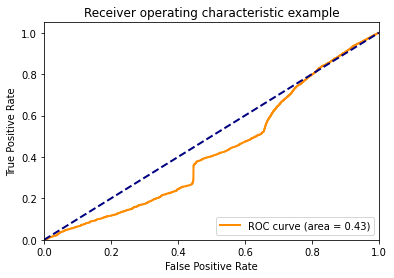

value_pack_test :  [array([0.45143231, 0.44622991, 0.47960445, 0.42805206, 0.59710609]), array([0.35995185, 0.44955451, 0.38113497, 0.38257663, 0.73354793]), array([0.13100628, 0.50116857, 0.07258653, 0.24244195, 0.29954725]), array([0.50390117, 0.47742092, 0.56816865, 0.46487251, 0.58219409]), 0.21346304859959864, 0.2887037198615595, 0.2722130122444231, 0.22562021929441875, 0.4390832678940174, 0.4390832678940174, 0.4390832678940174, 0.4390832678940174, 0.4390832678940174, 0.4390832678940174, 0.4390832678940174, (0.4390832678940174, 0.4390832678940174, 0.4390832678940174, None), 0.3520363651412099, 0.43248619311869196, 0.43248619311869196]
Check of results :  [[[0, 0, [0, 1, 2, 3, 4, 5, 6], 0.6608582562056607, 0.6608582562056607, 0.6608582562056607, 0.7169753684977814, 0.6608582562056607, 0.6608582562056607, 0.6608582562056607, 0.7169753684977814, [('joy2derv', 0.143851389011118, 0.0017480821539078613), ('freq_fres', 0.04093695913637833, 0.0009560907323612815), ('joy', 0.04057173868403

In [4]:
def classify(featlab_new, results, ynum):
    # Loop over each model to test
    num_of_models = 8

    for wm in range(num_of_models):
        res_permod = []
        for fea in range(4):
            print('fea : ', fea)

            # Selects the feature columns from the Dataframe per fea 
            X_train, X_test, Y_train_1D, Y_test_1D, desired_col = preprocess_df_2_XYtraintest(featlab_new, fea, ynum)
            
            # Determine if classes are binary or multiclass:
            class_len = len(np.unique(Y_train_1D))
            if class_len <= 2:
                cltype = 'bin'
            elif class_len > 2:
                cltype = 'multi'
            
            if wm == 0:
                # Stochastic Gradient Descent
                m_name = 'SGD'
                if cltype == 'bin':
                    model, Y_train_1D_predict, Y_test_1D_predict, Y_train_bin_pp, Y_test_bin_pp, Y_train_1D_score, Y_test_1D_score = binary_stochastic_gradient_descent(X_train, X_test, Y_train_1D, Y_test_1D)
                elif cltype == 'multi':
                    
            elif wm == 1:
                m_name = 'LDA'
                # 2-class Linear Discriminant Analysis (LDA)
                model, Y_train_1D_predict, Y_test_1D_predict, Y_train_bin_pp, Y_test_bin_pp, Y_train_1D_score, Y_test_1D_score = binary_LDA_classifier(X_train, X_test, Y_train_1D, Y_test_1D)
            elif wm == 2:
                m_name = 'NuSVC'
                # 2-class Support Vector Machine (NuSVC)
                model, Y_train_1D_predict, Y_test_1D_predict, Y_train_bin_pp, Y_test_bin_pp, Y_train_1D_score, Y_test_1D_score = binary_svm_NuSVC(X_train, X_test, Y_train_1D, Y_test_1D)
            elif wm == 3:
                m_name = 'RF'
                # 2-class RandomForest
                model, Y_train_1D_predict, Y_test_1D_predict, Y_train_bin_pp, Y_test_bin_pp, Y_train_1D_score, Y_test_1D_score = binary_RandomForest(X_train, X_test, Y_train_1D, Y_test_1D)
            elif wm == 4:
                m_name = 'GBC'
                # 2-class Gradient Boosting Classifier (gradient descent w/ logistic regression cost function)
                model, Y_train_1D_predict, Y_test_1D_predict, Y_train_bin_pp, Y_test_bin_pp, Y_train_1D_score, Y_test_1D_score = binary_GradientBoostingClassifier(X_train, X_test, Y_train_1D, Y_test_1D)
            elif wm == 5:
                m_name = 'DT'
                # 2-class Decision Tree Classifier
                model, Y_train_1D_predict, Y_test_1D_predict, Y_train_bin_pp, Y_test_bin_pp, Y_train_1D_score, Y_test_1D_score = binary_Decision_Tree_Classifier(X_train, X_test, Y_train_1D, Y_test_1D)
            elif wm == 6:
                m_name = 'MLP'
                # 2-class Multilayer perceptron (MLP)/neural network (Deep Learning) : logistic regression NN
                model, Y_train_1D_predict, Y_test_1D_predict, Y_train_bin_pp, Y_test_bin_pp, Y_train_1D_score, Y_test_1D_score = binary_multilayer_perceptron(X_train, X_test, Y_train_1D, Y_test_1D)
            elif wm == 7:
                m_name = 'GNB'
                # 2-class Gaussian Naive Bayes
                model, Y_train_1D_predict, Y_test_1D_predict, Y_train_bin_pp, Y_test_bin_pp, Y_train_1D_score, Y_test_1D_score = binary_gaussian_naive_bayes(X_train, X_test, Y_train_1D, Y_test_1D)
            
            
            value_pack_train = evaluation_methods_binary_class(model, X_train, Y_train_1D, Y_train_1D_predict, Y_train_bin_pp, Y_train_1D_score)
            print('value_pack_train : ', value_pack_train)

            acc_train = value_pack_train[8]
            prec_train = value_pack_train[9]
            recall_train = value_pack_train[10]
            roc_auc_train = value_pack_train[18]

            value_pack_test = evaluation_methods_binary_class(model, X_test, Y_test_1D, Y_test_1D_predict, Y_test_bin_pp, Y_test_1D_score)
            print('value_pack_test : ', value_pack_test)

            acc_test = value_pack_train[8]
            prec_test = value_pack_train[9]
            recall_test = value_pack_train[10]
            roc_auc_test = value_pack_train[18]

            # ----------------
            # Permutation importance of features : probe which features are most predictive
            if fea == 0:
                feature_names = ['joy', 'joy1derv', 'joy2derv', 'fres', 'freq_t', 'freq_fres']
                ovtot = pipeline_permutation_importance(model, X_test, Y_test_1D, feature_names)
            else:
                ovtot.append('na')
            # ----------------

            # ----------------
            # Save all data to array
            res_permod.append([ynum, m_name, fea, desired_col, acc_train, prec_train, recall_train, roc_auc_train, acc_test, prec_test, recall_test, roc_auc_test, ovtot])
            # ----------------

        # Results grouped per ynum (label number)
        results.append(res_permod)
        print('Check of results : ', results)

    return results

# Batch runs

In [ ]:
def run_main_script(exp, ax_val, ss_val):
    df = get_df(ax_val, ss_val)
    feat0, t_feat0, y1_feat0, y2_feat0, y3_feat0 = create_labels_and_initial_feature(df) 

    norm_feat0, norm_feat1, norm_feat2, norm_feat3, feat4, feat4_1 = feature_creation_preprocessing(feat0, t_feat0)

    y_alllabel = [y1_feat0, y2_feat0, y3_feat0]

    num_of_y = len(y_alllabel)
    num_of_y = 1  #test

    results = []
    for ynum in range(num_of_y):
        # print('ynum : ', ynum)
        y_label = y_alllabel[ynum]

        # ----------------

        samp_f0, samp_f1, samp_f2, samp_f3, samp_f4, samp_f4_1, y_check_org = get_feature_samples_per_label(norm_feat0, norm_feat1, norm_feat2, norm_feat3, feat4, feat4_1, y_label)

        # ----------------

        print('y_check_org ', y_check_org)
        print('length of norm_feat0 before padding: ', len(norm_feat0))

        norm_feat0, norm_feat1, norm_feat2, norm_feat3, feat4, feat4_1, y_label = pad_data_2makeclasses_equivalent(norm_feat0, norm_feat1, norm_feat2, norm_feat3, feat4, feat4_1, y_label, samp_f0, samp_f1, samp_f2, samp_f3, samp_f4, samp_f4_1, y_check_org)
        print('length of norm_feat0 after padding: ', len(norm_feat0))

        # ----------------

        # Put the padded features in the dataFrame
        data = norm_feat0, norm_feat1, norm_feat2, norm_feat3, feat4, feat4_1, y_label
        data = np.transpose(data)
        print('shape of data : ', data.shape)

        columns = list(range(data.shape[1]))
        featlab_new = pd.DataFrame(data=data, columns=columns)
        # print('shape of featlab_new : ', featlab_new.shape)

        # ----------------
        
        # classification for 3 partitions of feature data per 8 classifiers, 
        # results for each model are saved to pickle file
        results = classify(featlab_new, results, ynum)

    # Save data matrices to file per experiment
    file_name = "res_exp_%s_%s_%s.pkl" % (exp, ax_val, ss_val)
    open_file = open(file_name, "wb")
    pickle.dump(results, open_file)
    open_file.close()

    del results, file_name, open_file, exp, ax_val, ss_val
    
    return

In [ ]:
exp = 'rot'
ax_val = 'all'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

In [ ]:
# ------------------------------
# Manual runs
# Justification for not doing a loop : Can not do a loop because the computer stops or it stops 
# for weird reasons.  Have to run each manually.
# ------------------------------


# -------------
# DONE
# -------------

exp = 'rot'
ax_val = 'all'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

exp = 'rot'
ax_val = 'all'
ss_val = 'sub'
run_main_script(exp, ax_val, ss_val)

exp = 'rot'
ax_val = 'all'
ss_val = 'sup'
run_main_script(exp, ax_val, ss_val)

# -------------

exp = 'trans'
ax_val = 'all'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

exp = 'trans'
ax_val = 'all'
ss_val = 'sub'
run_main_script(exp, ax_val, ss_val)

exp = 'trans'
ax_val = 'all'
ss_val = 'sup'
run_main_script(exp, ax_val, ss_val)

# -------------

exp = 'rot'
ax_val = 'ax0'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

exp = 'rot'
ax_val = 'ax1'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

exp = 'rot'
ax_val = 'ax2'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

# -------------

exp = 'trans'
ax_val = 'ax0'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)

exp = 'trans'
ax_val = 'ax1'
ss_val = 'all'
run_main_script(exp, ax_val, ss_val)


## Barplots 

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd

import pickle

# Personal python functions
import sys
sys.path.insert(1, 'C:\\Users\\jamilah\\Documents\\Sourceforge_analysis_PROJECTS\\Motor_classification')
from subfunctions.make_a_properlist import *

outer3_name = ['rot', 'trans']
lab = ['lenient', 'strict']

df2plot = pd.DataFrame()

for exp in range(len(outer3_name)):
    if exp == 0:
        exp_name = 'Rotation'
        anom = 'RO', 'PI', 'YA'
    else:
        exp_name = 'Translation'
        anom = 'LR', 'FB', 'UD'
    
    # ax_val = 'all'
    ax_type = ['all', 'ax0', 'ax1', 'ax2']
    for ax_val in ax_type:
        
        if ax_val == 'all':
            ss_choices = ['all', 'sub', 'sup']
            print('ss_choices : ', ss_choices)
        else:
            ss_choices = ['all']

        for ss_val in ss_choices:
            # print('ss_val : ', ss_val)
            i=0
            for y in range(2):   # number of labels
                # Load .pkl file
                file_name = "res_exp_%s_%s_%s.pkl" % (outer3_name[exp], ax_val, ss_val)
                open_file = open(file_name, "rb")
                dataout = pickle.load(open_file)
                open_file.close()

                # Put data into dataFrame
                col0 = pd.Series(outer3_name[exp])  # exp
                col1 = pd.Series(ax_val)  # ax
                col2 = pd.Series(ss_val)  # ss
                col3 = pd.Series(lab[y])  # y

                col4 = pd.Series(dataout[i][4])  # accuracy_all  acc_test_mean
                col5 = pd.Series(dataout[i+1][4])  # accuracy_top3
                col6 = pd.Series(dataout[i+2][4]) # accuracy_top2
                col7 = pd.Series(dataout[i+3][4])  # accuracy_top1

                col8 = pd.Series(dataout[i][5])  # precision_all
                col9 = pd.Series(dataout[i+1][5])  # precision_top3
                col10 = pd.Series(dataout[i+2][5]) # precision_top2
                col11 = pd.Series(dataout[i+3][5])  # precision_top1

                col12 = pd.Series(dataout[i][7][0][0]) # per_order_1
                col13 = pd.Series(dataout[i][7][1][0])  # per_order_2
                col14 = pd.Series(dataout[i][7][2][0])  # per_order_3
                plot_label = '%s %s %s %s' % (outer3_name[exp], ax_val, ss_val, lab[y])
                col15 = pd.Series(plot_label)

                temp = pd.concat([col0, col1, col2, col3, col4, col5, col6, col7, col8, col9, col10, col11, col12, col13, col14, col15], axis=1)
                temp = temp.rename({0: 'exp', 1: 'ax', 2: 'ss', 3: 'y', 4: 'accuracy_all', 5: 'accuracy_top3', 6: 'accuracy_top2', 7: 'accuracy_top1', 8: 'precision_all', 9: 'precision_top3', 10: 'precision_top2', 11: 'precision_top1', 12: 'per_order_1', 13: 'per_order_2', 14: 'per_order_3', 15: 'plot_label'}, axis=1)
                df2plot = pd.concat([temp, df2plot], axis=0)
                i = i + 4

In [ ]:
df2plot

# Accuracy scatter plot of all categories: 

In [ ]:
textval = "all "
oo = textval*len(np.ravel(df2plot.accuracy_all.to_numpy()))
aa1 = pd.Series(oo.split())

textval = "top3 "
oo = textval*len(np.ravel(df2plot.accuracy_top3.to_numpy()))
aa2 = pd.Series(oo.split())

textval = "top2 "
oo = textval*len(np.ravel(df2plot.accuracy_top2.to_numpy()))
aa3 = pd.Series(oo.split())

textval = "top1 "
oo = textval*len(np.ravel(df2plot.accuracy_top1.to_numpy()))
aa4 = pd.Series(oo.split())

textstack = pd.concat([aa1, aa2, aa3, aa4], axis=0)
print('length of textstack', len(textstack))
catstack = pd.concat([df2plot.accuracy_all, df2plot.accuracy_top3, df2plot.accuracy_top2, df2plot.accuracy_top1], axis=0)
print('length of catstack', len(catstack))

stplot_label = df2plot.plot_label.to_numpy(),df2plot.plot_label.to_numpy(),df2plot.plot_label.to_numpy(),df2plot.plot_label.to_numpy()
stplot_label = np.ravel(stplot_label)


stexp = df2plot.exp.to_numpy(),df2plot.exp.to_numpy(),df2plot.exp.to_numpy(),df2plot.exp.to_numpy()
stexp = np.ravel(stexp)

stax = df2plot.ax.to_numpy(),df2plot.ax.to_numpy(),df2plot.ax.to_numpy(),df2plot.ax.to_numpy()
stax = np.ravel(stax)

stss = df2plot.ss.to_numpy(),df2plot.ss.to_numpy(),df2plot.ss.to_numpy(),df2plot.ss.to_numpy()
stss = np.ravel(stss)

sty = df2plot.y.to_numpy(),df2plot.y.to_numpy(),df2plot.y.to_numpy(),df2plot.y.to_numpy()
sty = np.ravel(sty)




dat = catstack.to_numpy(), textstack.to_numpy(), stplot_label, stexp, stax, stss, sty
dat1 = np.transpose(dat)
print('shape of dat1', dat1.shape)
columns = ['acc', 'Data used', 'plot_label', 'exp', 'ax', 'ss', 'y']
out = pd.DataFrame(data=dat1, columns=columns)
out

In [ ]:
# Scatterplot accuracy big

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20,10))

sns.set(font_scale = 1.7)
sns.scatterplot(x=out["acc"], y=out["plot_label"], hue=out["Data used"], alpha = 1, s=300, legend=True)

# ax[0].set_ylabel(fontsize=22)
ax.set_ylabel('Classification categories', fontsize=22)

ax.set_xlabel('Accuracy', fontsize=22)

In [ ]:
# Scatterplot accuracy looking at all data, sub, sup separately

out_acc_s = out[(out.y == 'strict')]
out_acc_l = out[(out.y == 'lenient')]

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(20,10))

sns.set(font_scale = 1.7) # default is without style and palette
sns.scatterplot(x=out_acc_s["acc"], y=out_acc_s["plot_label"], hue=out_acc_s["Data used"], ax=ax[0], alpha = 1, s=500, legend=True)
sns.scatterplot(x=out_acc_l["acc"], y=out_acc_l["plot_label"], hue=out_acc_l["Data used"], ax=ax[1], alpha = 1, s=500, legend=False)

# ax[0].set_ylabel(fontsize=22)
ax[0].set_ylabel('', fontsize=22)
ax[1].set_ylabel(' ')
# ax[1].set_yticks([])

ax[0].set_xlabel('', fontsize=22)
# ax[1].set_xlabel('Accuracy', fontsize=22)
ax[0].set_xlabel('', fontsize=22)
ax[1].set_xlabel('Accuracy', fontsize=22)

ax[0].set_xlim([0.4, 1])
ax[1].set_xlim([0.4, 1])

plt.savefig('Accuracy_comparisons.png')

# Precision scatter plot of all categories: 

In [ ]:
textval = "all "
oo = textval*len(np.ravel(df2plot.precision_all.to_numpy()))
aa1 = pd.Series(oo.split())

textval = "top3 "
oo = textval*len(np.ravel(df2plot.precision_top3.to_numpy()))
aa2 = pd.Series(oo.split())

textval = "top2 "
oo = textval*len(np.ravel(df2plot.precision_top2.to_numpy()))
aa3 = pd.Series(oo.split())

textval = "top1 "
oo = textval*len(np.ravel(df2plot.precision_top1.to_numpy()))
aa4 = pd.Series(oo.split())

textstack = pd.concat([aa1, aa2, aa3, aa4], axis=0)
print('length of textstack', len(textstack))
catstack = pd.concat([df2plot.precision_all, df2plot.precision_top3, df2plot.precision_top2, df2plot.precision_top1], axis=0)
print('length of catstack', len(catstack))

stplot_label = df2plot.plot_label.to_numpy(),df2plot.plot_label.to_numpy(),df2plot.plot_label.to_numpy(),df2plot.plot_label.to_numpy()
stplot_label = np.ravel(stplot_label)


stexp = df2plot.exp.to_numpy(),df2plot.exp.to_numpy(),df2plot.exp.to_numpy(),df2plot.exp.to_numpy()
stexp = np.ravel(stexp)

stax = df2plot.ax.to_numpy(),df2plot.ax.to_numpy(),df2plot.ax.to_numpy(),df2plot.ax.to_numpy()
stax = np.ravel(stax)

stss = df2plot.ss.to_numpy(),df2plot.ss.to_numpy(),df2plot.ss.to_numpy(),df2plot.ss.to_numpy()
stss = np.ravel(stss)

sty = df2plot.y.to_numpy(),df2plot.y.to_numpy(),df2plot.y.to_numpy(),df2plot.y.to_numpy()
sty = np.ravel(sty)

dat = catstack.to_numpy(), textstack.to_numpy(), stplot_label, stexp, stax, stss, sty
dat1 = np.transpose(dat)
print('shape of dat1', dat1.shape)
columns = ['pre', 'Data used', 'plot_label', 'exp', 'ax', 'ss', 'y']
pre_out = pd.DataFrame(data=dat1, columns=columns)
pre_out

In [ ]:
# Scatterplot accuracy big

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20,10))

sns.set(font_scale = 1.7)
sns.scatterplot(x=pre_out["pre"], y=pre_out["plot_label"], hue=pre_out["Data used"], alpha = 1, s=300, legend=True)

# ax[0].set_ylabel(fontsize=22)
ax.set_ylabel('Classification categories', fontsize=22)

ax.set_xlabel('Precision', fontsize=22)

In [ ]:
# Scatterplot precision looking at all data, sub, sup separately

out_pre_s = pre_out[(pre_out.y == 'strict')]
out_pre_l = pre_out[(pre_out.y == 'lenient')]

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(20,10))

sns.set(font_scale = 1.7) # default is without style and palette
sns.scatterplot(x=out_pre_s["pre"], y=out_pre_s["plot_label"], hue=out_pre_s["Data used"], ax=ax[0], alpha = 1, s=500, legend=True)
sns.scatterplot(x=out_pre_l["pre"], y=out_pre_l["plot_label"], hue=out_pre_l["Data used"], ax=ax[1], alpha = 1, s=500, legend=False)

# ax[0].set_ylabel(fontsize=22)
ax[0].set_ylabel('', fontsize=22)
ax[1].set_ylabel(' ')
# ax[1].set_yticks([])

ax[0].set_xlabel('', fontsize=22)
# ax[1].set_xlabel('Precision', fontsize=22)
ax[0].set_xlabel('', fontsize=22)
ax[1].set_xlabel('Precision', fontsize=22)

ax[0].set_xlim([0.4, 1])
ax[1].set_xlim([0.4, 1])

plt.savefig('Precision_comparisons.png')

In [ ]:
# Mixed accuracy and precision figure : strict

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(20,10))

sns.set(font_scale = 1.7) # default is without style and palette
sns.scatterplot(x=out_acc_s["acc"], y=out_acc_s["plot_label"], hue=out_acc_s["Data used"], ax=ax[0], alpha = 1, s=500, legend=True)
sns.scatterplot(x=out_pre_s["pre"], y=out_pre_s["plot_label"], hue=out_pre_s["Data used"], ax=ax[1], alpha = 1, s=500, legend=False)

# ax[0].set_ylabel(fontsize=22)
ax[0].set_ylabel('', fontsize=22)
ax[1].set_ylabel(' ')
# ax[1].set_yticks([])

ax[0].set_xlabel('Accuracy', fontsize=22)
ax[1].set_xlabel('Precision', fontsize=22)

ax[0].set_xlim([0.4, 1])
ax[1].set_xlim([0.4, 1])

plt.tight_layout()
plt.savefig('Acc_pre_comparisons_strict.png')

In [ ]:
# Mixed accuracy and precision figure : strict

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(20,10))

sns.set(font_scale = 1.7) # default is without style and palette
sns.scatterplot(x=out_acc_l["acc"], y=out_acc_l["plot_label"], hue=out_acc_l["Data used"], ax=ax[0], alpha = 1, s=500, legend=True)
sns.scatterplot(x=out_pre_l["pre"], y=out_pre_l["plot_label"], hue=out_pre_l["Data used"], ax=ax[1], alpha = 1, s=500, legend=False)

# ax[0].set_ylabel(fontsize=22)
ax[0].set_ylabel('', fontsize=22)
ax[1].set_ylabel(' ')
# ax[1].set_yticks([])

ax[0].set_xlabel('Accuracy', fontsize=22)
ax[1].set_xlabel('Precision', fontsize=22)

ax[0].set_xlim([0.4, 1])
ax[1].set_xlim([0.4, 1])

plt.tight_layout()
plt.savefig('Acc_pre_comparisons_lenient.png')

In [ ]:
# show the feature order of importance
def str2numvec(vec):
    num1 = []
    for i, doc in enumerate(vec):
        if doc == 'joy':
            num1.append(1)
        elif doc == 'joy1derv':
            num1.append(2)
        elif doc == 'joy2derv':
            num1.append(3)
        elif doc == 'fres':
            num1.append(4)
        elif doc == 'freq_fres':
            num1.append(5)
    return num1

In [ ]:
dat1

In [ ]:
num1 = str2numvec(df2plot.per_order_1.to_numpy())
num2 = str2numvec(df2plot.per_order_2.to_numpy())
num3 = str2numvec(df2plot.per_order_3.to_numpy())

col0 = pd.Series(df2plot.plot_label.to_numpy())
col1 = pd.Series(df2plot.y.to_numpy())
col2 = pd.Series(num1)
col3 = pd.Series(num2)
col4 = pd.Series(num3)
temp = pd.concat([col0, col1, col2, col3, col4], axis=1)

outout = temp.rename({0: 'plot_label', 1: 'y', 2: 'per_order_1', 3: 'per_order_2', 4: 'per_order_3'}, axis=1)
outout

In [ ]:
# Scatterplot accuracy looking at all data, sub, sup separately

out_s = outout[(outout.y == 'strict')]
out_l = outout[(outout.y == 'lenient')]

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(20,10))

dot_size = 300

sns.set(font_scale = 1.7) # default is without style and palette
sns.scatterplot(x=out_s["per_order_1"], y=out_s["plot_label"],  ax=ax[0], alpha=1, s=dot_size, legend=True)
sns.scatterplot(x=out_s["per_order_2"], y=out_s["plot_label"],  ax=ax[0], alpha=1, s=dot_size, legend=True)
sns.scatterplot(x=out_s["per_order_3"], y=out_s["plot_label"],  ax=ax[0], alpha=1, s=dot_size, legend=True)

sns.scatterplot(x=out_l["per_order_1"], y=out_l["plot_label"], ax=ax[1], alpha=1, s=dot_size, legend=True)
sns.scatterplot(x=out_l["per_order_2"], y=out_l["plot_label"], ax=ax[1], alpha=1, s=dot_size, legend=True)
sns.scatterplot(x=out_l["per_order_3"], y=out_l["plot_label"], ax=ax[1], alpha=1, s=dot_size, legend=True)


# ax[0].set_ylabel(fontsize=22)
ax[0].set_ylabel('', fontsize=22)
ax[1].set_ylabel(' ')
# ax[1].set_yticks([])

ax[0].set_xlabel('', fontsize=22)
# ax[1].set_xlabel('Precision', fontsize=22)
ax[0].set_xlabel('', fontsize=22)
ax[1].set_xlabel('Type of feature', fontsize=22)

ax[0].set_xlim([0, 6])
ax[1].set_xlim([0, 6])
ax[0].set_xticklabels(['', 'joy', 'joy1derv', 'joy2derv', 'fres', 'freq_fres'])  # Set text labels
ax[1].set_xticklabels(['', 'joy', 'joy1derv', 'joy2derv', 'fres', 'freq_fres'])  # Set text labels

# plt.savefig('Feature_comparisons.png')

# Negative can not put the legend on because the data is not stacked to give the hue a value

In [ ]:
# Scatterplot accuracy looking at all data, sub, sup separately

out_s = outout[(outout.y == 'strict')]
out_l = outout[(outout.y == 'lenient')]


# Make another DataFrame : stack all data to get hue column
col1 = out_s["per_order_1"].to_numpy(), out_s["per_order_2"].to_numpy(), out_s["per_order_3"].to_numpy()
col1 = make_a_properlist(col1)
# print('col1 : ', col1)
col2 = out_s["plot_label"].to_numpy(), out_s["plot_label"].to_numpy(), out_s["plot_label"].to_numpy()
col2 = make_a_properlist(col2)
# print('col2 : ', col2)
col3 = np.ones((len(out_s["per_order_1"].to_numpy()), 1)), 2*np.ones((len(out_s["per_order_2"].to_numpy()), 1)), 3*np.ones((len(out_s["per_order_3"].to_numpy()), 1))
col3 = make_a_properlist(col3)
# print('col3 : ', col3)
data = col1, col2, col3
data = np.transpose(data)
# print('shape of data : ', data.shape)
columns = ['perm_order', 'plot_label', 'order']
df_str = pd.DataFrame(data=data, columns=columns)

col1 = out_l["per_order_1"].to_numpy(), out_l["per_order_2"].to_numpy(), out_l["per_order_3"].to_numpy()
col1 = make_a_properlist(col1)
col2 = out_l["plot_label"].to_numpy(), out_l["plot_label"].to_numpy(), out_l["plot_label"].to_numpy()
col2 = make_a_properlist(col2)
col3 = np.ones((len(out_l["per_order_1"].to_numpy()), 1)), 2*np.ones((len(out_l["per_order_2"].to_numpy()), 1)), 3*np.ones((len(out_l["per_order_3"].to_numpy()), 1))
col3 = make_a_properlist(col3)
data = col1, col2, col3
data = np.transpose(data)
columns = ['perm_order', 'plot_label', 'order']
df_len = pd.DataFrame(data=data, columns=columns)

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(20,10))

dot_size = 300

sns.set(font_scale = 1.7) # default is without style and palette

# But, the columns are in the order of the data
# sns.scatterplot(x=df_str["perm_order"], y=df_str["plot_label"], hue=df_str["order"], palette="tab10", ax=ax[0], alpha=1, s=dot_size, legend=True)
# OR
# Orders the columns in the order that you wish, but you can not invert the x and y axis
sns.stripplot(x=df_str["plot_label"], y=df_str["perm_order"], hue=df_str["order"], order=['trans ax2 all strict','trans ax1 all strict','trans ax0 all strict', 'trans all sup strict', 'trans all sub strict', 'trans all all strict', 'rot ax2 all strict','rot ax1 all strict','rot ax0 all strict', 'rot all sup strict', 'rot all sub strict', 'rot all all strict'], ax=ax[0])

sns.scatterplot(x=df_len["perm_order"], y=df_len["plot_label"], hue=df_len["order"], palette="tab10", ax=ax[1], alpha=1, s=dot_size, legend=False)



# ax[0].set_ylabel(fontsize=22)
ax[0].set_ylabel('', fontsize=22)
ax[1].set_ylabel(' ')
# ax[1].set_yticks([])

ax[0].set_xlabel('', fontsize=22)
ax[1].set_xlabel('Type of feature', fontsize=22)

# ax[0].set_xticks([0, 1, 2, 3, 4, 5, 6])
# ax[1].set_xticks([0, 1, 2, 3, 4, 5, 6])

# ax[0].set_xlim([0, 6])
# ax[1].set_xlim([0, 6])
# ax[0].set_xticklabels(['', 'pos', 'vel', 'acc', 'fres', 'freq_fres'])  # Set text labels
# ax[1].set_xticklabels(['', 'pos', 'vel', 'acc', 'fres', 'freq_fres'])  # Set text labels

# Not what we want but at least we have a legend, that we could paste onto the better plot